In [36]:
import pandas as pd

data = pd.read_csv('heart.csv')

data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

In [37]:
from scipy.stats import pearsonr
# Correlation between age and maximum heart rate achieved 

age = data['age']
thalach = data['thalach']

# Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(age, thalach)
correlation_coefficient, p_value

(-0.390227075031593, 1.273826677207126e-38)

In [35]:
from scipy.stats import chi2_contingency

#  Difference in presence of heart disease between sexes
contingency_table = pd.crosstab(data['sex'], data['target'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
chi2, p_value

(78.86305133922973, 6.656820681726434e-19)

In [38]:
# Kruskal-Wallis Test
from scipy import stats
groups_oldpeak = []
for cp_type in data['cp'].unique():
    groups_oldpeak.append(data[data['cp'] == cp_type]['oldpeak'])

stat_oldpeak, p_oldpeak = stats.kruskal(*groups_oldpeak)
stat_oldpeak, p_oldpeak

(155.14756036832839, 2.0427749504531067e-33)

In [39]:
import numpy as np

group0 = data[data['target'] == 0]['thalach']  
group1 = data[data['target'] == 1]['thalach']  

# difference in means
obs_diff = np.mean(group1) - np.mean(group0)

combined = np.concatenate([group0, group1])

# Bootstrap
bootstrap_diffs = []
n_bootstraps = 10000
size_group0 = len(group0)
size_group1 = len(group1)

for _ in range(n_bootstraps):
    bootstrap_sample = np.random.choice(combined, size=len(combined), replace=True)
    bootstrap_mean0 = np.mean(bootstrap_sample[:size_group0])
    bootstrap_mean1 = np.mean(bootstrap_sample[size_group0:])
    bootstrap_diffs.append(bootstrap_mean1 - bootstrap_mean0)

# p-value
p_value = np.sum(np.abs(bootstrap_diffs) >= np.abs(obs_diff)) / n_bootstraps

obs_diff, p_value

(19.455290809756377, 0.0)

In [40]:
group0_oldpeak = data[data['target'] == 0]['oldpeak']  
group1_oldpeak = data[data['target'] == 1]['oldpeak'] 

obs_diff_medians = np.median(group1_oldpeak) - np.median(group0_oldpeak)

combined_oldpeak = np.concatenate([group0_oldpeak, group1_oldpeak])

# Permutation test procedure
perm_diffs_medians = []

for _ in range(n_bootstraps):
    # Shuffle 
    permuted = np.random.permutation(combined_oldpeak)
    
    # Split  into two parts
    perm_group0 = permuted[:size_group0]
    perm_group1 = permuted[size_group0:]
    
    # difference in medians
    perm_diff_medians = np.median(perm_group1) - np.median(perm_group0)
    perm_diffs_medians.append(perm_diff_medians)

# p-value
p_value_perm = np.sum(np.abs(perm_diffs_medians) >= np.abs(obs_diff_medians)) / n_bootstraps

obs_diff_medians, p_value_perm

(-1.2, 0.0)

In [41]:
from scipy.stats import shapiro

# Check normality of 'thalach' for each 'cp' group using Shapiro-Wilk test
normality_results = {cp: shapiro(group['thalach']) for cp, group in data.groupby('cp')}

# Extract p-values for easier interpretation
normality_p_values = {cp: result.pvalue for cp, result in normality_results.items()}

normality_p_values

{0: 0.00031674717320129275,
 1: 5.99200166107039e-06,
 2: 4.683775589597872e-09,
 3: 0.005916512571275234}

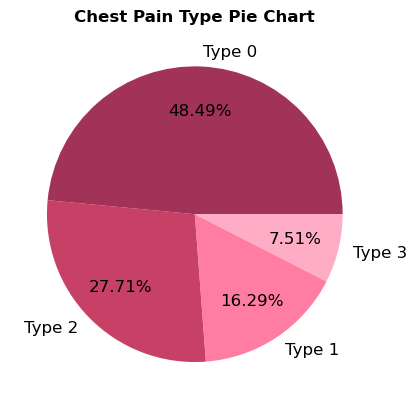

In [60]:
import matplotlib.pyplot as plt
colors= ['#8A0030', '#BA1141', '#FF5C8A', '#FF99B9', '#FFDEEB']
labels=['Type 0', 'Type 2', 'Type 1', 'Type 3']
order=data['cp'].value_counts().index
plt.title('Chest Pain Type Pie Chart', fontweight='bold')
plt.pie(data['cp'].value_counts(), labels=labels, colors=colors, pctdistance=0.7, 
        autopct='%.2f%%', textprops={'fontsize':12},
        wedgeprops=dict(alpha=0.8))
centre=plt.Circle((0, 0), 0.45, fc='white')

In [42]:
from scipy.stats import f_oneway
#  ANOVA

# Group data by 'cp' categories
thalach_groups = [data[data['cp'] == cp]['thalach'] for cp in data['cp'].unique()]

anova_result = f_oneway(*thalach_groups)
anova_result.statistic, anova_result.pvalue

(62.86280351279049, 2.6707219809486804e-37)

In [43]:
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

cp_groups = data['cp'].unique()
pairwise_comparisons = [(i, j) for i in cp_groups for j in cp_groups if i < j]

# Perform pairwise t-tests for 'cp' groups
p_values = []
for group1, group2 in pairwise_comparisons:
    data_group1 = data[data['cp'] == group1]['thalach']
    data_group2 = data[data['cp'] == group2]['thalach']
    t_stat, p_val = ttest_ind(data_group1, data_group2)
    p_values.append(p_val)

# Bonferroni correction
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')

# Result
bonferroni_results = dict(zip(pairwise_comparisons, zip(reject, pvals_corrected)))
bonferroni_results

{(0, 1): (True, 4.178793811590396e-26),
 (0, 2): (True, 5.415146775808371e-19),
 (0, 3): (True, 7.720638422538131e-09),
 (1, 2): (True, 0.0010928458591402189),
 (1, 3): (False, 0.36832577723163296),
 (2, 3): (False, 1.0)}

In [44]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_result = pairwise_tukeyhsd(endog=data['thalach'], groups=data['cp'], alpha=0.05)

tukey_result.summary()

<class 'statsmodels.iolib.table.SimpleTable'>